# Load data

In [1]:
import csv
import numpy as np

X = []
y = []
metadata = []

with open('primary_dataset.csv', 'r') as f:
    data = list(csv.reader(f))

header = data[0][6:36]
for line in data[1:]:
    scorer, video, diagnosis, age, sex = line[2], line[3], line[36], line[37], line[38]
    qs = line[6:36]
        
    # Remove scores with missing questions
    if len([x for x in qs if x == '']) == 0:
        X.append([int(x) for x in qs])
        y.append(int(diagnosis == 'asd'))
        metadata.append([scorer, video, age, sex])

X = np.asarray(X)
y = np.asarray(y)
m, n = X.shape

print('X', X.shape)
print('y', y.shape)
print('Unique videos', len(set([x[1] for x in metadata])))
print('scorers', len(set([x[0] for x in metadata])))
print('% missing', np.sum(X>=7)/(X.shape[0]*X.shape[1]))

X (529, 30)
y (529,)
Unique videos 181
scorers 7
% missing 0.13862633900441085


# Split train/test
We tried splitting by video and also by rater. At first, we thought correlation might exists between two different raters rating the same video. However, after some experimentation we noticed that each rater seems to have his/her own technique and we were overfitting to rater more than to video. 

In [2]:
import random
import math
from itertools import chain

def split_by_video(videos, k):
    shuffled_videos = list(videos)
    random.shuffle(shuffled_videos)
    num_videos_per_group = int(math.floor(len(shuffled_videos)/k))
    split = []
    videos = []
    for i in range(k):
        split_videos = set(shuffled_videos[(num_videos_per_group*i):(num_videos_per_group*(i+1))])
        split.append(list(np.where([x[1] in split_videos for x in metadata])[0]))
        videos.append(split_videos)
    return split, videos

def split_by_rater(raters, k):
    shuffled_raters = list(raters)
    random.shuffle(shuffled_raters)
    num_raters_per_group = int(math.floor(len(shuffled_raters)/k))
    split = []
    raters = []
    for i in range(k):
        split_raters = set(shuffled_raters[(num_raters_per_group*i):(num_raters_per_group*(i+1))])
        split.append(list(np.where([x[0] in split_raters for x in metadata])[0]))
        raters.append(split_raters)
    return split, raters


unique_videos = set([x[1] for x in metadata])
print('unique videos', len(unique_videos))

unique_raters = set([x[0] for x in metadata])
print('unique raters', len(unique_raters))

split, videos = split_by_video(unique_videos, 5) #batches of 5
test_indices, test_videos = np.asarray(split[0]), videos[0]
train_indices, train_videos = np.asarray(list(chain.from_iterable(split[1:5]))), set(chain.from_iterable(videos[1:5]))

#split, raters = split_by_rater(unique_raters, 3)
#test_indices, test_raters = np.asarray(split[0]), raters[0]
#train_indices, train_raters = np.asarray(list(chain.from_iterable(split[1:3]))), set(chain.from_iterable(raters[1:3]))

print('train_videos', len(train_videos))
print('test_videos', len(test_videos))
#print('train raters', len(train_raters))
#print('test raters', len(test_raters))
print(train_indices.shape, test_indices.shape)

unique videos 181
unique raters 7
train_videos 144
test_videos 36
(420,) (107,)


# Basic L1 and L2 Models
Take a quick look at performance of L2 vs L1 regularization. However, we need to take these results with a grain of salt since I haven't tuned any of the parameters.

In [3]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc

def print_stats(model, X_train, y_train, X_test, y_test):
    # Nonzero entries
    print('nonzero coefficients:', np.sum(model.coef_[0]!=0), 'out of', model.coef_.shape[1])

    # Accuracy
    print('train accuracy:', sgdc.score(X_train, y_train))
    print('test accuracy:', sgdc.score(X_test, y_test))
    
    # AUC
    yhat = sgdc.predict_proba(X_train)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train, yhat)
    print('train auc:', auc(fpr, tpr))
    yhat = sgdc.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, yhat)
    print('test auc:', auc(fpr, tpr))

# ---------------------------- L2 ----------------------------
print('L2 Raw Data')
sgdc = SGDClassifier(loss="log", penalty='l2', alpha=0.1, fit_intercept=True)
sgdc.fit(X[train_indices, :], y[train_indices])
print_stats(sgdc, X[train_indices, :], y[train_indices], X[test_indices, :], y[test_indices])

# ---------------------------- L1 ----------------------------
print('\nL1 Raw Data')
sgdc = SGDClassifier(loss="log", penalty='l1', alpha=0.05, fit_intercept=True)
sgdc.fit(X[train_indices, :], y[train_indices])
print_stats(sgdc, X[train_indices, :], y[train_indices], X[test_indices, :], y[test_indices])


L2 Raw Data
nonzero coefficients: 30 out of 30
train accuracy: 0.9023809523809524
test accuracy: 0.8785046728971962
train auc: 0.9657179987004548
test auc: 0.9393039049235994

L1 Raw Data
nonzero coefficients: 7 out of 30
train accuracy: 0.9023809523809524
test accuracy: 0.8504672897196262
train auc: 0.9565821962313189
test auc: 0.9422750424448216


# Tune an L2 Model
We start by tuning an L2 model. This let's us know the best possible performance we can expect from this data.

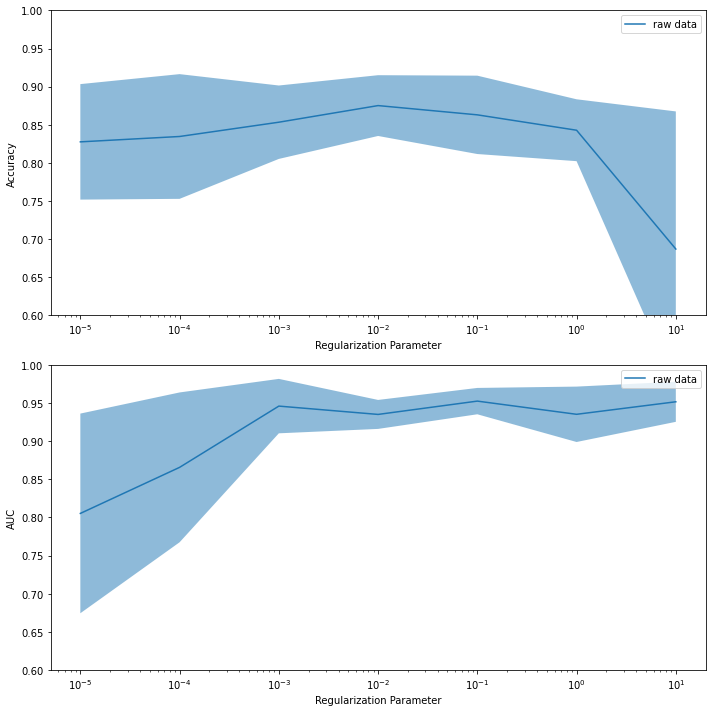

In [4]:
import matplotlib.pyplot as plt
import scipy.stats as st

def tune_L2(X, k, alphas):
    accuracy_avg = []
    accuracy_err = []
    auc_avg = []
    auc_err = []

    for alpha in alphas:
        accuracy = np.zeros((k,))
        auroc = np.zeros((k,))

        for i, (split_test_indices, split_test_videos) in enumerate(zip(*split_by_video(train_videos, k))):
            split_train_indices = list(set(train_indices) - set(split_test_indices))

            # fit model
            sgdc = SGDClassifier(loss="log", penalty='l2', alpha=alpha, fit_intercept=True)
            sgdc.fit(X[split_train_indices, :], y[split_train_indices])

            # accuracy
            accuracy[i] = sgdc.score(X[split_test_indices, :], y[split_test_indices])

            # auc
            yhat = sgdc.predict_proba(X[split_test_indices, :])[:, 1]
            fpr, tpr, thresholds = roc_curve(y[split_test_indices], yhat)
            auroc[i] = auc(fpr, tpr)

        # calculate mean and 95% confidence intervals
        accuracy_avg.append(np.mean(accuracy))
        ci = st.t.interval(0.95, k-1, loc=np.mean(accuracy), scale=st.sem(accuracy))
        accuracy_err.append((ci[1]-ci[0])/2)
        auc_avg.append(np.mean(auroc))
        ci = st.t.interval(0.95, k-1, loc=np.mean(auroc), scale=st.sem(auroc))
        auc_err.append((ci[1]-ci[0])/2)
    return accuracy_avg, accuracy_err, auc_avg, auc_err
    

k = 5
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
accuracy_avg_raw, accuracy_err_raw, auc_avg_raw, auc_err_raw = tune_L2(X, k, alphas)
plt.figure(figsize=(10, 10))

# Accuracy
ax1 = plt.subplot(2, 1, 1)

plt.plot(alphas, accuracy_avg_raw, label='raw data')
plt.fill_between(alphas, [x+e for x, e in zip(accuracy_avg_raw, accuracy_err_raw)], [x-e for x, e in zip(accuracy_avg_raw, accuracy_err_raw)], alpha=0.5)

plt.xlabel('Regularization Parameter')
plt.ylabel('Accuracy')
plt.ylim([0.6, 1])
plt.xscale('log')
plt.legend()

# AUC
plt.subplot(2, 1, 2, sharex=ax1)

plt.plot(alphas, auc_avg_raw, label='raw data')
plt.fill_between(alphas, [x+e for x, e in zip(auc_avg_raw, auc_err_raw)], [x-e for x, e in zip(auc_avg_raw, auc_err_raw)], alpha=0.5)

plt.xlabel('Regularization Parameter')
plt.ylabel('AUC')
plt.ylim([0.6, 1])
plt.xscale('log')
plt.legend()

plt.tight_layout()
plt.show()   


# Tune an Elastic Net Model
The challenge in tuning an elastic net model is that we have two parameters to consider:
    1. alpha: the amount of regularization 
    2. l1_ratio: the ratio between L1 and L2 regularization
We're interested in understanding how performance (measured by accuracy and AUC) vary with the number of parameters used. To do this, we'll start by fixing alpha, and then varying the l1_ratio to see a range of models with differing number of parameters.

C:\Users\sarth\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\sarth\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\Users\sarth\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\sarth\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\Users\sarth\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\sarth\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in mult

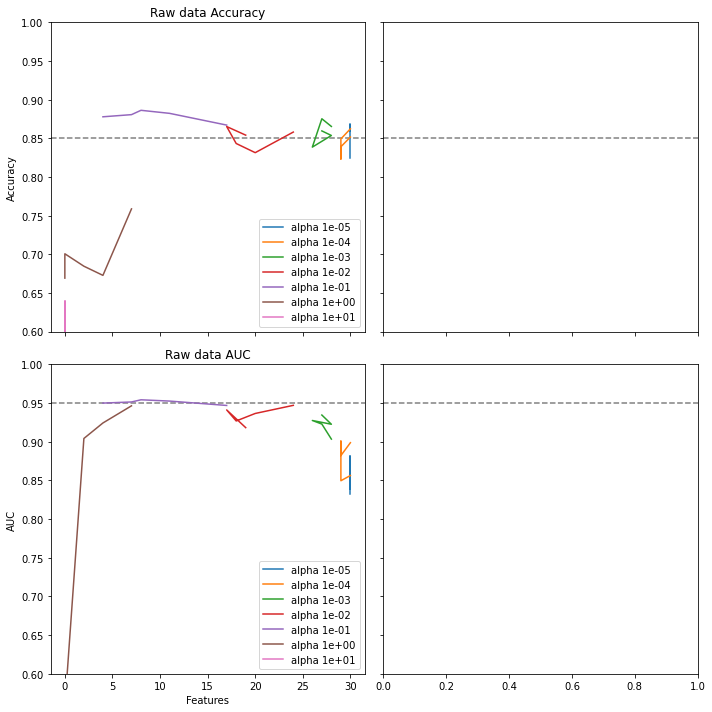

In [5]:
def tune_l1_ratio(X, k, alpha, l1_ratios):
    accuracy_avg = []
    accuracy_err = []
    auc_avg = []
    auc_err = []
    nzcoeffs_median = []

    for l1_ratio in l1_ratios:
        accuracy = np.zeros((k,))
        auroc = np.zeros((k,))
        nzcoeffs = np.zeros((k,))

        for i, (split_test_indices, split_test_videos) in enumerate(zip(*split_by_video(train_videos, k))):
            split_train_indices = list(set(train_indices) - set(split_test_indices))

            # fit model
            sgdc = SGDClassifier(loss="log", penalty='elasticnet', alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True)
            sgdc.fit(X[split_train_indices, :], y[split_train_indices])

            # accuracy
            accuracy[i] = sgdc.score(X[split_test_indices, :], y[split_test_indices])

            # auc
            yhat = sgdc.predict_proba(X[split_test_indices, :])[:, 1]
            fpr, tpr, thresholds = roc_curve(y[split_test_indices], yhat)
            auroc[i] = auc(fpr, tpr)
            
            # nonzero coeffs
            nzcoeffs[i] = np.sum(sgdc.coef_[0]!=0)

        # calculate mean and 95% confidence intervals
        accuracy_avg.append(np.mean(accuracy))
        ci = st.t.interval(0.95, k-1, loc=np.mean(accuracy), scale=st.sem(accuracy))
        accuracy_err.append((ci[1]-ci[0])/2)
        auc_avg.append(np.mean(auroc))
        ci = st.t.interval(0.95, k-1, loc=np.mean(auroc), scale=st.sem(auroc))
        auc_err.append((ci[1]-ci[0])/2)
        nzcoeffs_median.append(np.median(nzcoeffs))
    return accuracy_avg, accuracy_err, auc_avg, auc_err, nzcoeffs_median

k = 5
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
l1_ratios = [0.2, 0.4, 0.6, 0.8, 1.0]


fig, axes = plt.subplots(2, 2, sharex='col', sharey=True, figsize=(10, 10))
axes[0, 0].axhline(y=0.85, linestyle='--', color='black', alpha=0.5)
axes[0, 1].axhline(y=0.85, linestyle='--', color='black', alpha=0.5)
axes[1, 0].axhline(y=0.95, linestyle='--', color='black', alpha=0.5)
axes[1, 1].axhline(y=0.95, linestyle='--', color='black', alpha=0.5)

for alpha in alphas:
    accuracy_avg_raw, accuracy_err_raw, auc_avg_raw, auc_err_raw, nzcoeffs_median_raw = tune_l1_ratio(X, k, alpha, l1_ratios)
    # Accuracy
    axes[0, 0].plot(nzcoeffs_median_raw, accuracy_avg_raw, label='alpha %.0e' % alpha)
    #axes[0, 0].fill_between(nzcoeffs_median_raw, [x+e for x, e in zip(accuracy_avg_raw, accuracy_err_raw)], [x-e for x, e in zip(accuracy_avg_raw, accuracy_err_raw)], alpha=0.5)
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_ylim([0.6, 1])
    axes[0, 0].set_title('Raw data Accuracy')
    axes[0, 0].legend()
    
    
    # AUC
    axes[1, 0].plot(nzcoeffs_median_raw, auc_avg_raw, label='alpha %.0e' % alpha)
    #axes[1, 0].fill_between(nzcoeffs_median_raw, [x+e for x, e in zip(auc_avg_raw, auc_err_raw)], [x-e for x, e in zip(auc_avg_raw, auc_err_raw)], alpha=0.5)
    axes[1, 0].set_xlabel('Features')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].set_ylim([0.6, 1])
    axes[1, 0].set_title('Raw data AUC')
    axes[1, 0].legend()

plt.tight_layout()
plt.show()   

Looking at these plots, we can easily choose alpha for each dataset. For the raw data, we should use alpha=0.1.

nonzero coefficients: 30 out of 30
train accuracy: 0.8928571428571429
test accuracy: 0.8317757009345794
train auc: 0.9741130604288498
test auc: 0.9142614601018676
nonzero coefficients: 7 out of 30
train accuracy: 0.8904761904761904
test accuracy: 0.8598130841121495
train auc: 0.9477712800519817
test auc: 0.9475806451612903
questions used ['question1', 'question4', 'question7', 'question9', 'question10', 'question11', 'question25']


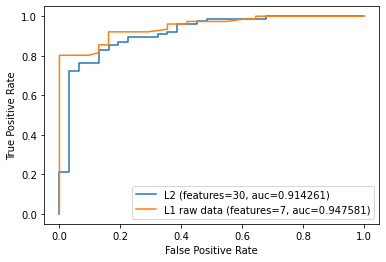

In [6]:
# Best L2
sgdc = SGDClassifier(loss="log", penalty='l2', alpha=0.01, fit_intercept=True)
sgdc.fit(X[train_indices, :], y[train_indices])
print_stats(sgdc, X[train_indices, :], y[train_indices], X[test_indices, :], y[test_indices])

yhat = sgdc.predict_proba(X[test_indices, :])[:, 1]
fpr, tpr, thresholds = roc_curve(y[test_indices], yhat)
nnz = np.sum(sgdc.coef_[0]!=0)
plt.plot(fpr, tpr, label='L2 (features=%d, auc=%f)' % (nnz, auc(fpr, tpr)))

# Best Raw data L1
sgdc = SGDClassifier(loss="log", penalty='elasticnet', alpha=0.1, l1_ratio=0.9, fit_intercept=True)
sgdc.fit(X[train_indices, :], y[train_indices])
print_stats(sgdc, X[train_indices, :], y[train_indices], X[test_indices, :], y[test_indices])

yhat = sgdc.predict_proba(X[test_indices, :])[:, 1]
fpr, tpr, thresholds = roc_curve(y[test_indices], yhat)
nnz = np.sum(sgdc.coef_[0]!=0)
print('questions used', [header[i] for i, x in enumerate(sgdc.coef_[0]) if x != 0])
plt.plot(fpr, tpr, label='L1 raw data (features=%d, auc=%f)' % (nnz, auc(fpr, tpr)))


plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

So our L1-regularized models are performing about as well as our L2 model, even though they're using fewer features.

In [7]:
train_prevalence = np.sum(y[train_indices])
print('train prevalence', np.sum(y[train_indices]/len(train_indices)))
print('test prevalence', np.sum(y[test_indices]/len(test_indices)))
print(np.shape(train_indices), np.shape(test_indices))

train prevalence 0.6785714285714286
test prevalence 0.7102803738317757
(420,) (107,)


If we take a look at train prevalence vs test prevalance, we see they they do differ by quite a bit.